In [2]:
%load_ext rpy2.ipython
from IPython.display import FileLink

In [23]:
%%R
library(dplyr)
library(ggplot2)
library(rwantshue)
library(grid); library(gridExtra)
library(magrittr)

In [4]:
%%R
mdf = tbl_df(data.table::fread("../data/mdf.csv"))

Read 2195072 rows and 18 (of 18) columns from 0.435 GB file in 00:00:04


In [5]:
%%R
bulk.df = mdf %>%
    filter(grepl("bulk", Sample)) %>%
    group_by(Sample) %>%
    mutate(relative.abundance = Abundance / sum(Abundance)) %>%
    group_by(OTU, Rank2, Rank3, Rank4, Day) %>%
    summarize(`Relative Abundance` = mean(relative.abundance)) %>%
    group_by()

In [20]:
%%R
df.l2fc = read.csv("../data/l2fc_table.csv")

df.l2fc %<>% {
    tmp = filter(., padj <= 0.10) %>%
        group_by(OTU, Treatment) %>%
        summarize(min.p = min(padj)) %>%
        group_by(OTU) %>%
        summarize(S = sum(min.p <= 0.10)) %>%
        mutate(rspnse = ifelse(S > 1, "both", "one")) %>%
        select(OTU, rspnse)
    df.l2fc %>% left_join(tmp)
    }

Joining by: "OTU"


In [27]:
%%R
FDR = 0.10

minP.df = df.l2fc %>%
    group_by(OTU, Treatment, rspnse) %>%
    summarize(minP = min(padj)) %>%
    filter(minP <= FDR) %>%
    group_by()

Joining by: "OTU"


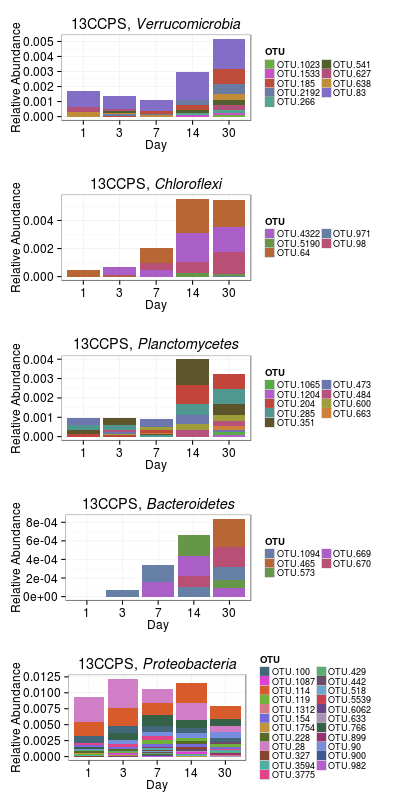

In [28]:
%%R -w 400 -h 800

scheme = iwanthue()

phyla = c("Verrucomicrobia", "Chloroflexi", "Planctomycetes", "Bacteroidetes", "Proteobacteria")
t = "13CCPS"

d = minP.df %>% 
    filter(Treatment == t) %>%
    inner_join(bulk.df) %>%
    filter(Rank2 %in% phyla, !(rspnse == "both")) %>%
    arrange(Rank2, `Relative Abundance`)

plot = function(r, d) {
    plot.d = d %>% filter(Rank2 == r)
    colors = scheme$hex(length(unique(plot.d$OTU)), color_space = hcl_presets$intense)

    p = ggplot(plot.d, aes(x = factor(Day), y = `Relative Abundance`, fill = OTU))

    p = p + geom_bar(stat = "identity")
    
    p = p + labs(x = "Day")

    p = p + scale_fill_manual(values = colors)
    
    p = p + guides(fill = guide_legend(ncol = 2))
    
    p = p + theme_bw()
    
    p = p + theme(axis.text = element_text(size = 12),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9))
    
    p = p + ggtitle(substitute(paste(a, ",", " ", italic(b), sep = ""), 
                               list(a = t, b = r)))

    p}
    
plots.13CCPS = lapply(phyla, plot, d = d)

do.call(grid.arrange, c(plots.13CCPS,list(ncol=1)))

Joining by: "OTU"


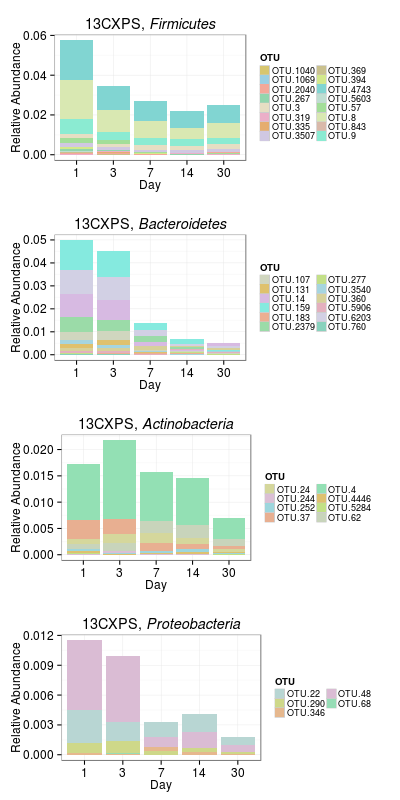

In [29]:
%%R -w 400 -h 800

scheme = iwanthue()

phyla = c("Firmicutes", "Bacteroidetes", "Actinobacteria", "Proteobacteria")
t = "13CXPS"

d = minP.df %>% 
    filter(Treatment == t) %>%
    inner_join(bulk.df) %>%
    filter(Rank2 %in% phyla, !(rspnse == "both")) %>%
    arrange(Rank2, `Relative Abundance`)

plot = function(r, d) {
    plot.d = d %>% filter(Rank2 == r)
    colors = scheme$hex(length(unique(plot.d$OTU)), color_space = hcl_presets$pastel)

    p = ggplot(plot.d, aes(x = factor(Day), y = `Relative Abundance`, fill = OTU))

    p = p + geom_bar(stat = "identity")
    
    p = p + labs(x = "Day")

    p = p + scale_fill_manual(values = colors)
    
    p = p + theme_bw()
    
    p = p + guides(fill = guide_legend(ncol = 2))
        
    p = p + theme(axis.text = element_text(size = 12),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9))

    p = p + ggtitle(substitute(paste(a, ",", " ", italic(b), sep = ""), 
                               list(a = t, b = r)))
    p}
    
plots.13CXPS = lapply(phyla, plot, d = d)

do.call(grid.arrange, c(plots.13CXPS, list(ncol=1)))

Joining by: "OTU"


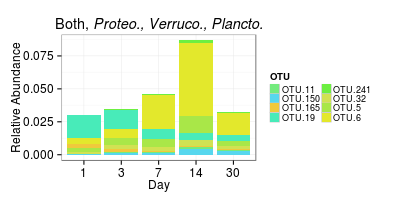

In [52]:
%%R -w 400 -h 200

scheme = iwanthue()

phyla = c("Proteobacteria", "Planctomycetes", "Verrucomicrobia")
#t = "13CXPS"

d = minP.df %>% 
#    filter(Treatment == t) %>%
    inner_join(bulk.df) %>%
    filter(Rank2 %in% phyla, rspnse == "both") %>%
    arrange(Rank2, `Relative Abundance`)

plot.dual = function(phyla, d) {
    plot.d = d %>% filter(Rank2 %in% phyla)
    colors = scheme$hex(length(unique(plot.d$OTU)), color_space = hcl_presets$fluo)

    p = ggplot(plot.d, aes(x = factor(Day), y = `Relative Abundance`, fill = OTU))

    p = p + geom_bar(stat = "identity")
    
    p = p + labs(x = "Day")

    p = p + scale_fill_manual(values = colors)
    
    p = p + theme_bw()
    
    p = p + guides(fill = guide_legend(ncol = 2))
        
    p = p + theme(axis.text = element_text(size = 12),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9))

    #p = p + ggtitle(substitute(paste(a, ",", " ", italic(b), sep = ""), 
    #                           list(a = t, b = r)))
    p}

p = plot.dual(phyla, d)

p = p + ggtitle(substitute(paste(a, ",", " ", italic(b), sep = ""),
                           list(a = "Both", b = "Proteo., Verruco., Plancto.")))

plots.dual = list(p)

p

#do.call(grid.arrange, c(plots.dual, list(ncol=1)))

In [33]:
%%R
df.l2fc %>% filter(rspnse == "both") %>% group_by(Rank2) %>% summarize(count = n())

Source: local data frame [3 x 2]

            Rank2 count
1  Planctomycetes     7
2  Proteobacteria    54
3 Verrucomicrobia     7


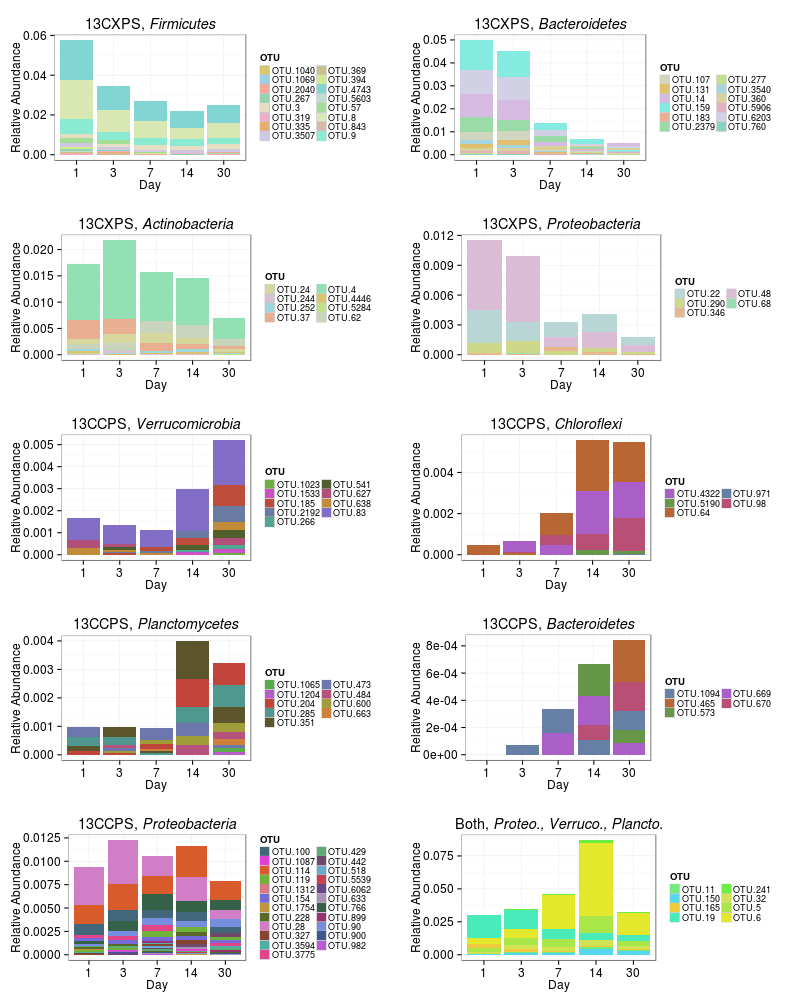

In [53]:
%%R -w 800 -h 1000
do.call(grid.arrange, c(plots.13CXPS, plots.13CCPS, plots.dual, list(ncol=2, nrow = 5)))

In [56]:
%%R
pdf("figs/abund_v_time_phyla.pdf", h = 14, w = 10)
do.call(grid.arrange, c(plots.13CXPS, plots.13CCPS, plots.dual, list(ncol=2, nrow = 5)))
dev.off()

png 
  2 


In [55]:
FileLink("figs/abund_v_time_phyla.pdf")

/home/chuck/working/CSIP_succession_data_analysis/figures_and_stats/figs/abund_v_time_phyla.pdf